<a href="https://colab.research.google.com/github/tbarton16/transformers/blob/main/transformer_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html?fbclid=IwAR1D94cCvEqwV4nB4EZV49x5eb6K6ALD_W1EXNNQVOYAFGAU7avXCa9Xz9M
! pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 28.9 MB/s 
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:45tcmalloc: large alloc 1147494400 bytes == 0x65e14000 @  0x7f6bce862615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |████████████████████████████████| 887.4 MB 1.7 kB/s 
     |████████████████████████████████| 140 kB 76.9 MB/s 
     |████████████████████████████████| 849 kB 73.6 MB/s 
     |████████████████████████████████| 317.1 MB 34 kB/s 
     |████████████████████████████████| 21.0 MB 980 kB/s 
     |████████████████████████████████| 557.1 MB 12 kB/s 
     |████████████████████████████████| 127 kB 74.4 MB/s 
  Attempting uninstall: ur

In [ ]:
import torch
import pdb
import numpy as np
import torch.nn.functional as F
from torchtext.datasets import WikiText2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class SingleHeadAttention(torch.nn.Module):
  """Neural Net architecture for single head of self-attention."""
  def __init__(self, batch_size, input_dim, dq, dv):
    """
    Args:
      input_size: int, input to this layer will have shape N x D
      input_size, input_dim where 1 is the batch_size.
      output_size: int, same as d_k in the paper.
    """
    super().__init__()
    # Define the layers, # todo verify intialization
    # dq == dk,v dv can differ
    self.WQ = torch.nn.Linear(input_dim, dq)  # (input_dim, output_dim) -> y N by outputsize = xW # score for word
    self.WK = torch.nn.Linear(input_dim, dq) #
    self.WV = torch.nn.Linear(input_dim, dv) # batch_size, dq WV
    self.dq = dq
    # Initialize the weights

  def forward(self, x):
    # (batch_size, input_dim)
    q, k, v = self.create_qkv(x)
    sdpa = self.scaled_dot_product_attn(q, k, v)
    return sdpa

  def create_qkv(self, x):
    q = self.WQ(x) # (batch_size, dq)
    k = self.WK(x) # (batch_size, dq)
    v = self.WV(x) # (batch_size, dv)
    return q, k, v 

  def scaled_dot_product_attn(self, Q, K, V):
    """Given Q, K, V, perform the scaled-dot-product attention.

    Args:
      Q: float tensor, N x N where N is the number of tokens in the sentence.
    
    """
    x = Q @ (K.T) #(batch_size, dq) (dq, batch_size) = (sentence, sentence)
    x_d = x / torch.sqrt(torch.tensor(self.dq))
    x_s = torch.nn.functional.softmax(x_d, dim=0)
    product = x_s @ V
    return product

In [ ]:
data = torch.rand(10, 4)
bart_tron = SingleHeadAttention(10, 4, 5, 3)
print(bart_tron(data)) # __ call

tensor([[ 0.0477, -0.2410, -0.0955],
        [ 0.0409, -0.2168, -0.0860],
        [ 0.0501, -0.2384, -0.0931],
        [ 0.0461, -0.2291, -0.0905],
        [ 0.0495, -0.2389, -0.0936],
        [ 0.0511, -0.2448, -0.0955],
        [ 0.0482, -0.2373, -0.0931],
        [ 0.0500, -0.2415, -0.0948],
        [ 0.0433, -0.2179, -0.0864],
        [ 0.0474, -0.2348, -0.0929]], grad_fn=<MmBackward0>)


## Create the dataset

## Embedding

tensor([[7, 1, 8, 3, 7, 1, 9, 5, 2, 6]])


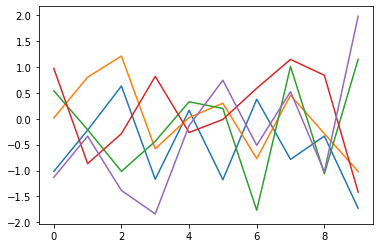

In [ ]:
class EmbeddingModule(torch.nn.Module):
  """ Word embedding, wordToken -> longer numbers """

  def __init__(self, vocab_size, embedding_size):
    """Args: None"""
    super().__init__()
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.layer = torch.nn.Embedding(self.vocab_size, self.embedding_size) # 

  def forward(self, x): # [context_length]
    return self.layer(x) # (bsz=1, context_length, embedding_size)

class PositionalEmbedding(torch.nn.Module):
  """ Encode position using either learned or  sin and cos """

  def __init__(self, context_len, embedding_size, use_learned_embedding=True):
    """ embed stuff, should uptput something like context_len by embeddingh size
    """
    super().__init__()
    self.context_len = context_len
    self.embedding_size = embedding_size
    self.use_learned_embedding = use_learned_embedding

    if self.use_learned_embedding:
      # map (bsz=1, contextlen) -> (bsz=1, embedding_size)
      self.layer = torch.nn.Embedding(self.context_len, self.embedding_size)
    else: 
      self.layer = None
      
    self.to(device)
  
  def forward(self, x): #(bsz, context_len)
    if self.use_learned_embedding:
      idxs = torch.arange(x.shape[-1], device=device)
      return self.layer(idxs)
    else:
      assert x.shape[-1] % 2 ==0
      d = x.shape[-1]
     # pdb.set_trace()
      k = np.arange(1, d  / 2 + 1) # [1, 1, 2, 2, 3, 3] 1 d
      k = np.expand_dims(k, axis=1)
      #k_2 = np.concatenate([k, k], axis=1) # [1 2 3],[1 2 3] # d / 2, 2 -> (1, d)
      #k_2 = k_2.reshape(-1)
      w_k = 1 / (1000 **(2 * k / d))

      cos_array = np.arange(0, d, 2) # even numbers
      sin_array = np.arange(1, d, 2) # odd numbers

      cos_array = np.cos(w_k * cos_array)
      sin_array = np.sin(w_k * sin_array)
      cos_array = cos_array[:, np.newaxis] # d/2, 1
      sin_array = sin_array[:, np.newaxis] # d/2, 1

      fin_array = np.concatenate([cos_array, sin_array], axis = 1) # d/2, 2
      fin_array = fin_array.reshape(-1)  # d/2*2
      return torch.from_numpy(fin_array)

x = torch.randint(0, 10, (1, 10))
e = PositionalEmbedding(10, 5, True)
f = EmbeddingModule(10, 5)
print(x)
# print(e(x))
# print(f(x))
from matplotlib import pyplot
with torch.no_grad():
  pyplot.plot(e(x).cpu().numpy())


In [ ]:
k = np.arange(1, 11); print(k)

[ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
np.concatenate((k[:, np.newaxis], k[:, np.newaxis]), axis=1).reshape(-1)[np.newaxis, :]

array([[ 1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10]])

In [ ]:
from matplotlib.cbook import file_requires_unicode
import re
from collections import defaultdict, Counter
_patterns = [r"\'", r"\"", r"\.", r"<br \/>", r",", r"\(", r"\)", r"\!", r"\?", r"\;", r"\:", r"\s+"]
_replacements = [" '  ", "", " . ", " ", " , ", " ( ", " ) ", " ! ", " ? ", " ", " ", " "]

_patterns_dict = list((re.compile(p), r) for p, r in zip(_patterns, _replacements))

class TokenTokenizer(object):
  """Turn text into eassily digestible tokens"""
  def __init__(self, vocab_size=50):
    self.patterns_dict = _patterns_dict
    self.vocab_size = vocab_size
    self.vocab = None
    self.merges = None
  
  def pre_tokenizer(self, text):
    text = text.lower()
    for pattern, repl in self.patterns_dict:
      re.sub(pattern, repl, text, count=100)
    return text

  def compute_pair_freqs(self, splits, word_freqs):
    pair_freqs = defaultdict(int)
    for word, ct in word_freqs.items():
      split = splits[word]
      if len(split) == 1:
        continue
      for i in range(len(split) - 1):
        pair = (split[i], split[i+1])
        pair_freqs[pair] += ct

    return pair_freqs
  
  def merge_pair(self, a, b, splits):
    for word, split in splits.items():
      if len(split) == 1:
        continue
      i=0
      while i<len(split) - 1:
        if split[i] == a and split[i+1] ==b:
          split = split[:i] + [a+b] + split[i+2:]
        else:
          i += 1
      splits[word] = split
    return splits


  def train_tokenize(self, text):
    text = self.pre_tokenizer(text)
    words = text.split()
    word_freq = Counter(words)
    vocab = []
    for w, ct in word_freq.items():
      for l in w:
        if l not in vocab:
          vocab.append(l)
    merges = {} # tuple to merge
    splits = {word: [ c for c in word] for word in word_freq.keys()}
    while len(vocab) < self.vocab_size:
      pair_freqs = self.compute_pair_freqs(splits, word_freq)
      best_pair, ct = max(pair_freqs.items(), key=lambda x: x[1])
      merges[best_pair] = best_pair[0] + best_pair[1]
      vocab.append(merges[best_pair])
      # apply the merge to the splits
      splits = self.merge_pair(*best_pair, splits)
    self.vocab = vocab
    self.merges=merges

# Write a bpe tokenizer for a corpus of text, consisting of training and segmentation
# 1. Throw away punctuation
# 2. Input, one long string or list of strings?
# 3. find top pairs
# 4. merge top pairs

  def tokenize(self, text):
    pass



examples = [("ASDFASDF", "asdfasdf"), (".", " .  ")]
examples = [("ASDFASDF", "asdf asdf"), ("aaaa ssss aa asdflkjzc,mvnawkeilkvzn", " .  ")]

t = TokenTokenizer(vocab_size=7)
for input, out in examples:
  print(t.train_tokenize(input), out)


None asdf asdf
None  .  


# Single Head attention

In [ ]:
class SingleHeadAttention2(torch.nn.Module):
  """ Computes single head of attention. """

  def __init__(self, batch_size, seq_len, input_dim, dk, dv):
    """Compute attention for an input of shape (seq_len, input_dim)
     Args: batch_size should be 1
           seq_len is the tokens
           input_dim is the len of embedding vector
    Outputs: attention() = Softmax(K @ Q/sqrt(dk)) @ V
    """
    super().__init__()
    self.batch_size = batch_size
    self.input_dim = input_dim
    self.dk = dk
    self.dv = dv
    # torch.nn -> Modules (layers) -- params that are maintained & updated
    # torch.nn.functional -> functions -- no params, just computation
    self.WQ = torch.nn.Linear(input_dim, dk).to(device)# (seq_len, input_dim) (input_dim, dk) ->(seq_len, dk)
    self.WK = torch.nn.Linear(input_dim, dk).to(device)# (seq_len, input_dim) (input_dim, dk) ->(seq_len, dk)
    self.WV = torch.nn.Linear(input_dim, dv).to(device)# (seq_len, seq_len) * (seq_len, dv) -> (seq_len, dv)

  def create_qkv_mat(self, x):
    """
    """
    Q = self.WQ(x) # x= (Seq_len, input_dim), Q = ()
    K = self.WK(x)
    #pdb.set_trace()
    V = self.WV(x)
    return Q, K, V

  def forward(self, x, use_mask=False):
    Q, K, V = self.create_qkv_mat(x)
    QK_t = Q @ K.T  # (seq_len, dk)(seq_len, dk).T = (seq_len, seq_len)
    if use_mask:
      mask = torch.tril(torch.ones_like(QK_t)).to(device)
      QK_t[mask==0] = -torch.inf #  (seq_len, seq_len)
      
    norm_qk_t = QK_t / torch.sqrt(torch.tensor(self.dk)) # (seq_len, seq_len)
    probs = F.softmax(norm_qk_t, dim=0) # (seq_len, seq_len)
    reweighted_V = probs @ V # (seq_len, seq_len) (seq_len, dv) 
    return reweighted_V

In [ ]:
F.softmax(torch.Tensor([0,0,-torch.inf,1]) , dim=0)

tensor([0.2119, 0.2119, 0.0000, 0.5761])

In [ ]:
data = torch.rand(10, 4)
bart_tron = SingleHeadAttention2(1, 10, 4, 5, 3)
print(bart_tron(data)) # __ call

tensor([[-0.1547, -0.4380, -0.1854],
        [-0.1666, -0.4731, -0.2169],
        [-0.1605, -0.4501, -0.2088],
        [-0.1645, -0.4650, -0.2198],
        [-0.1649, -0.4663, -0.2196],
        [-0.1561, -0.4391, -0.1937],
        [-0.1578, -0.4446, -0.2012],
        [-0.1560, -0.4433, -0.1919],
        [-0.1621, -0.4584, -0.2094],
        [-0.1711, -0.4876, -0.2355]], grad_fn=<MmBackward0>)


Untitled drawing.svg

## Multi Headed attention 

In [ ]:
class MultiHeadedAttention(torch.nn.Module):
  """For input, compute multi headed attention."""

  def __init__(self, batch_size, seq_len, input_dim, dk, dv, num_heads, output_dim, mask):
    super().__init__()
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.input_dim = input_dim
    self.dk = dk
    self.dv = dv
    self.num_heads = num_heads
    self.output_dim = output_dim
    self.mask = mask

    self.single_heads = [SingleHeadAttention2(self.batch_size, self.seq_len, self.input_dim, self.dk, self.dv) for i in range(self.num_heads)]
    # (seq_len, input_dim)
    # (seq_len, dv) -> (seq_len, dv * num_heads)
    self.linear_layer = torch.nn.Linear(self.dv * self.num_heads, self.output_dim)  

  def forward(self, x): # (seq_len, input_dim)
    attention_output = [head(x, use_mask=self.mask) for head in self.single_heads] # -> (seq_len, dv) * num_heads
    attention_concat = torch.concat(attention_output, dim=1) # -> (seq_len, dv * num_heads)
    output = self.linear_layer(attention_concat) # (seq_len, output_dim)
    return output

data = torch.rand(10, 4)
bart_tron = MultiHeadedAttention(1, 10, 4, 5, 3, 2, 7, False)
print(bart_tron(data)) 

RuntimeError: ignored

## Encoder Block

In [ ]:
class EncoderBlock(torch.nn.Module):
  """ One multi headed attention and one FF network """
  def __init__(self, batch_size, seq_len, input_dim, dk, dv, num_heads, output_dim):
    super().__init__()
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.input_dim = input_dim
    self.dk = dk
    self.dv = dv
    self.num_heads = num_heads
    self.output_dim = output_dim

    self.multi_headed_attention = MultiHeadedAttention(batch_size, seq_len, input_dim, dk, dv, num_heads, output_dim, mask=False) # (seq_len, output_dim)
    self.feed_forward = torch.nn.Sequential(
        torch.nn.Linear(output_dim, output_dim // 2),
        torch.nn.ReLU(),
        torch.nn.Linear(output_dim //2, output_dim))

  def forward(self, x):
    attention_output = self.multi_headed_attention(x) # (seq_len, output_dim)
    assert self.output_dim == self.input_dim
    attention_normed = F.layer_norm(x + attention_output, attention_output.shape)  # (seq_len, output_dim)

    output = self.feed_forward(attention_normed) # (seq_len, output_dim//2 )
    output_normed = F.layer_norm(output + attention_normed, output.shape)
    return output_normed

data = torch.rand(10, 4)
bart_tron = EncoderBlock(1, 10, 4, 5, 3, 2, 4)
print(bart_tron(data))

RuntimeError: ignored

In [ ]:
class DecoderBlock(torch.nn.Module):
  """ One masked multi headed attention, one unmasked multi headed attention and one FF network """
  def __init__(self, batch_size, seq_len, input_dim, dk, dv, num_heads, output_dim):
    super().__init__()
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.input_dim = input_dim
    self.dk = dk
    self.dv = dv
    self.num_heads = num_heads
    self.output_dim = output_dim
    self.masked_multi_headed_attention = MultiHeadedAttention(batch_size, seq_len, input_dim, dk, dv, num_heads, output_dim, mask=True) # (seq_len, output_dim)
    self.multi_headed_attention = MultiHeadedAttention(batch_size, seq_len, input_dim, dk, dv, num_heads, output_dim, mask=False) # (seq_len, output_dim)
    self.feed_forward = torch.nn.Sequential(
        torch.nn.Linear(output_dim, output_dim // 2),
        torch.nn.ReLU(),
        torch.nn.Linear(output_dim //2, output_dim))

  def forward(self, x):
    attention_output = self.masked_multi_headed_attention(x) # (seq_len, output_dim)
    assert self.output_dim == self.input_dim
    attention_normed = F.layer_norm(x + attention_output, attention_output.shape)  # (seq_len, output_dim)
    
    attention_output_2 = self.multi_headed_attention(attention_normed) # why not have a mask
    attention_output_2normed = F.layer_norm( attention_normed + attention_output_2, attention_output_2.shape )
    
    output = self.feed_forward(attention_output_2normed) # (seq_len,)
    output_normed = F.layer_norm(output + attention_normed, output.shape)
    return output_normed

# data = torch.rand(10, 4)
# bart_tron = DecoderBlock(1, 10, 4, 5, 3, 2, 4)
# print(bart_tron(data))

In [ ]:
class Transformer(torch.nn.Module):
  """Decoder only language model"""
  def __init__(self, vocab_size, batch_size, seq_len, input_dim, dk, dv,
               num_heads, output_dim, n_iter):
    super().__init__()
    #assert input_dim == output_dim ==dv
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.input_dim = input_dim
    self.dk = dk
    self.dv = dv
    self.num_heads = num_heads
    self.output_dim = output_dim
    self.vocab_size = vocab_size
    self.pos_embedding = PositionalEmbedding(seq_len, input_dim, True)
    self.embedding = EmbeddingModule(self.vocab_size, self.input_dim)
    self.n_iter = n_iter
    self.decoder = DecoderBlock(batch_size, seq_len, input_dim, dk, dv, num_heads, output_dim)
    self.linear = torch.nn.Linear(self.input_dim, self.vocab_size) # y =  (seq_len*output_dim) * m

  def forward(self, x): # (seq_len)
    pemb = self.pos_embedding(x) #(seq_len, input_dim)
    emb = self.embedding(x) #(seq_len, input_dim)
    emb = emb.reshape(self.seq_len, self.input_dim)
    output_sofar = emb + pemb # (seq_len, input_dim)
    #print(output_sofar.shape)
    for i in range(self.n_iter):
      output_sofar = self.decoder(output_sofar) # (seq_len, output_dim)
    vocab_scores = self.linear(output_sofar) # seq_len, vocab_size
    # vocab_probs = F.softmax(vocab_scores, dim=1)
    # return vocab_probs
    return vocab_scores

x = torch.randint(0, 10, (1, 10)).to(device)
tessnet = Transformer(vocab_size=50, batch_size=1, seq_len=10, input_dim=6,
                      dk=5, dv=3, num_heads=2, output_dim=6, n_iter=3).to(device)
ret = tessnet(x)
print(ret)

tensor([[-9.7888e-01, -4.3803e-02,  6.3744e-01,  5.6731e-01, -4.4684e-01,
          1.1047e-01, -1.7762e-01, -7.8596e-01,  8.3556e-01,  8.4169e-02,
         -3.9172e-01,  9.8802e-02, -1.1116e+00,  1.9350e-01, -5.1177e-01,
          8.9474e-01, -3.3718e-01, -9.0381e-02,  1.0305e-01,  2.4366e-01,
          3.8544e-02,  4.4166e-01,  2.7463e-01, -5.8168e-01,  6.2907e-01,
          9.2202e-02, -1.0096e+00, -5.9019e-02, -2.2597e-01,  1.1297e-01,
         -2.7611e-01, -4.2991e-01, -4.4143e-01, -6.7549e-01, -2.1527e-01,
         -4.6445e-01,  1.2388e-01,  4.9269e-01,  6.7246e-01, -8.2479e-01,
         -6.7629e-01, -5.8613e-01,  3.6058e-01, -4.4129e-01,  8.1227e-01,
          2.0587e-01, -7.1310e-01, -2.1889e-01,  8.3677e-01,  1.0875e-01],
        [-9.4309e-01, -1.7975e-02,  8.3512e-02,  8.1356e-01, -7.3327e-02,
          4.1351e-01,  2.7484e-01, -7.4846e-01,  9.8321e-01,  1.9517e-01,
         -3.7474e-01, -1.1777e-02, -1.0547e+00,  1.0992e-01, -4.1311e-01,
          8.9929e-01, -4.7590e-01, -2

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchdata.datapipes.iter.util.tfrecordloader import TFRecordExampleFeature

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english') # _basic_english_normalize, which normalize the string first and split by space.

vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>']) # any word not in vocabulary is unk
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter):
  """applies tokenization to vocab"""
  """Converts raw text into a flat Tensor."""
  data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

def chunker(data, window_size):
  """Creating input into smaller sequences"""
  seq_len = data.size(0) // window_size # num windows
  data = data[:seq_len * window_size] # drop_last=True
  data = data.view(window_size, seq_len).t().contiguous()
  return data.to(device)

window_size = 10
eval_window_size = 10
train_data = chunker(train_data, window_size)  # shape [seq_len, batch_size]
val_data = chunker(val_data, eval_window_size)
test_data = chunker(test_data, eval_window_size)

bptt = 1
def get_batch(source, i):
  seq_len = min(bptt, len(source) - 1 - i)
  data = source[i:i+seq_len]
  target = source[i+1:i+1+seq_len].reshape(-1)
  return data, target

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
ntokens = len(vocab)
epochs = 10

print(train_data.shape) # train_data = [seq_len, batch_size]
tessnet = Transformer(vocab_size=ntokens, batch_size=1, seq_len=10, input_dim=16,
                      dk=5, dv=10, num_heads=2, output_dim=16, n_iter=3).to(device)
optimizer = torch.optim.SGD(tessnet.parameters(), lr=5.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

tessnet.train()
print(device)
for i in range(epochs):
  for p in range(train_data.shape[0]):
    data, target = get_batch(train_data, p) # data is tokens, target is tokens
    #data = data.reshape(10)
    target = target.reshape(10)
    ## cross entropy loss
    #print(data)
    data = data.to(device)
    #print(next(tessnet.parameters()).is_cuda, data.is_cuda)
    pred = tessnet(data)
    #print(pred.view(-1, ntokens).shape, target.shape)
    loss = torch.nn.CrossEntropyLoss()
    output = loss(pred, target)
    
    optimizer.zero_grad()
    output.backward()
    torch.nn.utils.clip_grad_norm_(tessnet.parameters(), 0.5)
    optimizer.step()
    if p % 100 ==99:
      print(output.item())


torch.Size([204999, 10])
cuda
9.407470703125
8.549514770507812
8.150704383850098
8.068041801452637
7.712569236755371
8.697060585021973
7.427594184875488
8.379158020019531
7.042017459869385
7.030007362365723
9.458014488220215
6.34900426864624
8.666813850402832
8.984743118286133
8.003644943237305
7.869693756103516
8.297019004821777
7.932302951812744
7.850955009460449
7.639202117919922
7.164543151855469
7.44292688369751
8.805148124694824
7.069933891296387
8.83287525177002
7.141129970550537
7.47350549697876
6.714293479919434
10.11689567565918
7.7196550369262695
7.966147422790527
6.618116855621338
6.429417610168457
7.485820770263672
6.254817008972168
7.770826816558838
8.826681137084961
7.426016330718994
6.958164215087891
6.894402980804443
7.524172306060791
7.398170471191406
7.199459075927734
8.566872596740723
8.441158294677734
9.211034774780273
6.901258945465088
6.522246360778809
6.310817718505859
6.010660648345947
7.070153713226318
6.5841064453125
6.632681369781494
6.680120944976807
7.7823

RuntimeError: ignored